# Парсинг сайта, сбор содержимого страниц и сохранение результата

Для начала, импортируем необходимые библиотеки

In [1]:
import hashlib
import requests
import csv
import time
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

После этого задаем "константы":
- TIME_OF_WORK - общее время работы в часах
- REQUEST_INTERVAL_MIN - интервал обращения к сервису openphish в минутах
- REQUEST_INTERVAL_SEC - интервал обращения к сервису openphish в секундах
- OUTPUT_CSV_FILENAME - имя файла, в который будет писаться вывод программы в формате csv (url, target, time)
- OUTPUT_CONTENT_FILENAME - имя файла, в который будет писаться вывод программы в формате csv (url, page_content) - содержание фишинговой страницы

In [2]:
TIME_OF_WORK = 8
REQUEST_INTERVAL_MIN = 5
REQUEST_INTERVAL_SEC = REQUEST_INTERVAL_MIN * 60

OUTPUT_CSV_FILENAME = './result.csv'
OUTPUT_CONTENT_FILENAME = './pages_content.csv'

Вычисляем время начала работы скрипта, время окончания работы. 

Инициализируем также словарь, в котором будет содержаться результат работы программы.

Данный словарь по сути является хэш-таблицей, где ключ - sha256(url | target | time), а значением - JSON-объект с полями url, raw_target, time.

Использование данной структуры позволяет эффективно исключать дубли при повторных обращениях к сервису, а также фильтровать дубли, возникающие в самом сервисе (теоретически, у сервиса могут быть дубли в виде строк с двумя одинаковыми url и различными target, поэтому проверки по одному url может быть недостаточно)

In [3]:
start_of_working = datetime.now()
end_of_working = start_of_working + timedelta(hours=TIME_OF_WORK)

result_hash_table = {}

Описываем вспомогательные функции для преобразования словарей в списки, в которых будут также содержаться заголовки для CSV.

Результирующий файл переписывается после каждого обращения к сервису (для бэкапа)

Файл с контентом **дополняется** после каждой итерации с целью экономии памяти (т.к. содержимое страниц может занимать много памяти, переменная, хранящая их, перезаписывается в течение каждой итерации, а содержатся в ней только контент для новых страниц)

In [4]:
def convert_general_table_to_csv(table_to_convert):
    result = [['url', 'raw_target', 'time']]
    
    for elem in table_to_convert:
        result.append(list(table_to_convert[elem].values()))
    return result


def convert_pages_content_to_csv(table_to_convert, is_first=False):
    if is_first:
        result = [['url', 'content']]
    else:
        result = []

    for elem in table_to_convert:
        result.append(list(table_to_convert[elem].values()))
    return result

Описываем вспомогательные функции, предназначенные для записи результатов в файлы CSV 

In [5]:
def write_general_table_csv(csv_to_write):
    with open(OUTPUT_CSV_FILENAME, 'w', newline='', encoding='utf-8') as outp:
        csv_writer = csv.writer(outp, delimiter='|')
        for elem in csv_to_write:
            csv_writer.writerow(elem)


def write_pages_contetnt_csv(csv_to_write):
    with open(OUTPUT_CONTENT_FILENAME, 'a', newline='', encoding='utf-8') as outp:
        csv_writer = csv.writer(outp, delimiter='|')
        for elem in csv_to_write:
            csv_writer.writerow(elem)

Описываем функции, используемые для парсинга сервиса и сбора контента страниц:

Функция get_phishing_content получает содержимое страницы, располагающейся по переданному URL. Используется для сбора контента фишинговых сайтов.

Функция make_request_to_openphish выполняет запрос к сервису openphish и забирает все элементы из интересующей таблицы.

Функция parse_site выполняет текущую итерацию целиком. В неё передаётся предыдущий результат, после чего выполняется запрос к openphish и происходит обработка результатов:
- Для всех url, target, time из таблицы вычисляется хэш-сумма от их конкатенации и проверяется на наличии в предыдущих результатах;
- Для всех новых элементов производится GET-запрос для получения контента с соответствующих им страниц;
- Полученные результаты возвращаются в виде двух словарей. 

In [6]:
def parse_site(hash_table):
    result_pages_content = {}
    parsed_raw_results = make_request_to_openphish()

    count_of_new_findings = 0
    count_of_repeated_findings = 0

    for phished_url, raw_target, time_of_finding in parsed_raw_results:
        string_to_hash = f'{phished_url}:{raw_target}:{time_of_finding}'
        hash = hashlib.new('sha256')
        hash.update(str.encode(string_to_hash))
        hash_of_finding = hash.hexdigest()

        if hash_of_finding not in hash_table:
            count_of_new_findings += 1
            hash_table[hash_of_finding] = {
                'url': phished_url,
                'raw_target': raw_target,
                'time': time_of_finding
            }

            phishing_content = get_phishing_content(phished_url)
            if phishing_content:
                result_pages_content[phished_url] = {
                'url': phished_url,
                'content': phishing_content.replace('\n', '{replaced_nl}')
            }
        else:
            count_of_repeated_findings += 1
    
    print(f'\tFound {count_of_new_findings} new phishing urls')
    print(f'\tAnd {count_of_repeated_findings} urls were repeated')
    return hash_table, result_pages_content


def make_request_to_openphish():
    parsed_results = []
    url = 'https://openphish.com'
    res = requests.get(url)

    soup_parser = BeautifulSoup(res.text, 'html.parser')
    for elem in soup_parser.find_all('tr')[1:]:
        phished_url, raw_target, time_of_finding = elem.get_text().split('\n')[1:4]
        parsed_results.append((phished_url, raw_target, time_of_finding))

    return parsed_results


def get_phishing_content(phishing_url):
    try:
        res = requests.get(phishing_url, timeout=1)
        if res.status_code != 200:
            return None
        return res.text
    except Exception:
        return None

Описываем итоговую функцию run_parse, предназначенную для последовательного запуска итераций с ранее заданным интервалом.

Проверяется текущее время и сравнивается с временем окончания сбора результатов, после чего выполняется очередная итерация и производится сохранение результатов.

Далее выполняется задержка в указанной ранее длительности.

In [7]:
def run_parse(hash_table):
    current_time = datetime.now()
    iteration_number = 1
    while current_time < end_of_working:
        print(f'Run {iteration_number} iteration:')
        hash_table, result_pages_content = parse_site(hash_table)

        csv_result_table = convert_general_table_to_csv(hash_table)
        csv_pages_content = convert_pages_content_to_csv(result_pages_content, iteration_number==1)

        write_general_table_csv(csv_result_table)
        write_pages_contetnt_csv(csv_pages_content)

        print(f'Wait for next iteration')
        iteration_number += 1
        time.sleep(REQUEST_INTERVAL_SEC)
        current_time = datetime.now()

Запуск функции парсинга

In [8]:
run_parse(result_hash_table)

Run 1 iteration:
	Found 30 new phishing urls
	And 0 urls were repeated
Wait for next iteration
Run 2 iteration:
	Found 5 new phishing urls
	And 25 urls were repeated
Wait for next iteration
Run 3 iteration:
	Found 3 new phishing urls
	And 27 urls were repeated
Wait for next iteration
Run 4 iteration:
	Found 8 new phishing urls
	And 22 urls were repeated
Wait for next iteration
Run 5 iteration:
	Found 15 new phishing urls
	And 15 urls were repeated
Wait for next iteration
Run 6 iteration:
	Found 4 new phishing urls
	And 26 urls were repeated
Wait for next iteration
Run 7 iteration:
	Found 5 new phishing urls
	And 25 urls were repeated
Wait for next iteration
Run 8 iteration:
	Found 4 new phishing urls
	And 26 urls were repeated
Wait for next iteration
Run 9 iteration:
	Found 7 new phishing urls
	And 23 urls were repeated
Wait for next iteration
Run 10 iteration:
	Found 4 new phishing urls
	And 26 urls were repeated
Wait for next iteration
Run 11 iteration:
	Found 9 new phishing urls
	An

# Обработка данных

Импортируем дополнительные бибилиотеки, необходимые для визуализации данных

In [9]:
from matplotlib import pyplot

Загружаем из файла сохраненный CSV-файл. Сохраняем первые два столбца построчно в виде кортежей.

In [10]:
result_of_parsing = []
with open(OUTPUT_CSV_FILENAME, encoding='utf-8') as inp:
    csv_reader = csv.reader(inp, delimiter='|')
    next(csv_reader)
    for line in csv_reader:
        result_of_parsing.append((line[0], line[1]))

total_unique_urls = len(result_of_parsing)

Для начала, вычисляем общую статистику по всем целевым ресурсам и подсчитваем количество url для каждого из них.

In [11]:
targets_stat = {}
for url, target in result_of_parsing:
    if target not in targets_stat:
        targets_stat[target] = 1
    else:
        targets_stat[target] += 1

targets_stat = dict(sorted(targets_stat.items(), key=lambda x: -x[1]))

Описываем функцию, которая будет выполнять постройку диаграммы:
- pyplot.rcParams["figure.figsize"] = (10,5.5) позволяет настроить размер диаграммы
- graph_names - список наименований таргетов
- graph_values - список значений
- colors - список из цветов, содержит количество элементов равное количеству элементов в передаваемом в функцию словаре (настроена таким образом, чтобы цвета были градиентными от зеленого к красному)
- pyplot.bar - строит диаграмму
- ax.set_xticklabels([]) - убирает подписи под диаграммой
- pyplot.legend - строит легенду справа от диаграммы

In [12]:
def plot_graph(graph_to_plot, offset = 1):
    fig, ax = pyplot.subplots()
    pyplot.rcParams["figure.figsize"] = (10,5.5)

    graph_names = graph_to_plot.keys()
    graph_values = graph_to_plot.values()

    total_count_elements = len(graph_to_plot)
    colors = [(x/total_count_elements, 1 - x/total_count_elements, 0) for x in range(0, total_count_elements)]

    pyplot.bar(graph_names, graph_values, color=colors, label=graph_to_plot)
    ax.set_xticklabels([])
    pyplot.legend(bbox_to_anchor=(offset,1), ncol=3, fancybox=True, shadow=True)

Вызываем функцию построения диаграммы

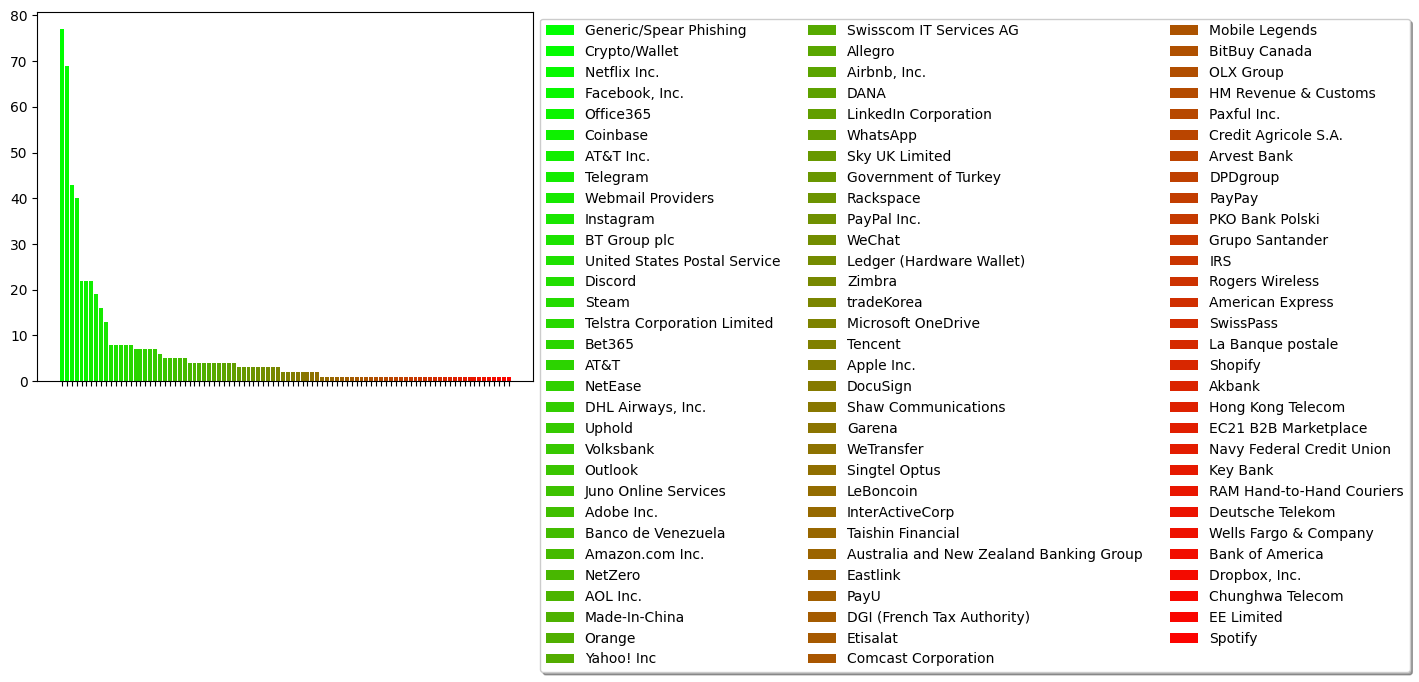

In [13]:
plot_graph(targets_stat)

Выполняем очистку наименований целевых сервисов:
- Убираем Generic/Spear Phishing и Crypto/Wallet, поскольку это не является наименованием сервисов
- Убираем Inc из названия в разных комбинациях

In [14]:
skipped_targets = ['Generic/Spear Phishing', 'Crypto/Wallet']


clean_targets_stat = {}
for url, target in result_of_parsing:
    if target in skipped_targets:
        continue

    clean_target = target.replace(', Inc.', '').replace(' Inc.', '').replace(', Inc', '').replace(' Inc', '')

    if clean_target not in clean_targets_stat:
        clean_targets_stat[clean_target] = 1
    else:
        clean_targets_stat[clean_target] += 1

clean_targets_stat = dict(sorted(clean_targets_stat.items(), key=lambda x: -x[1]))

Вызываем функцию построения диаграммы

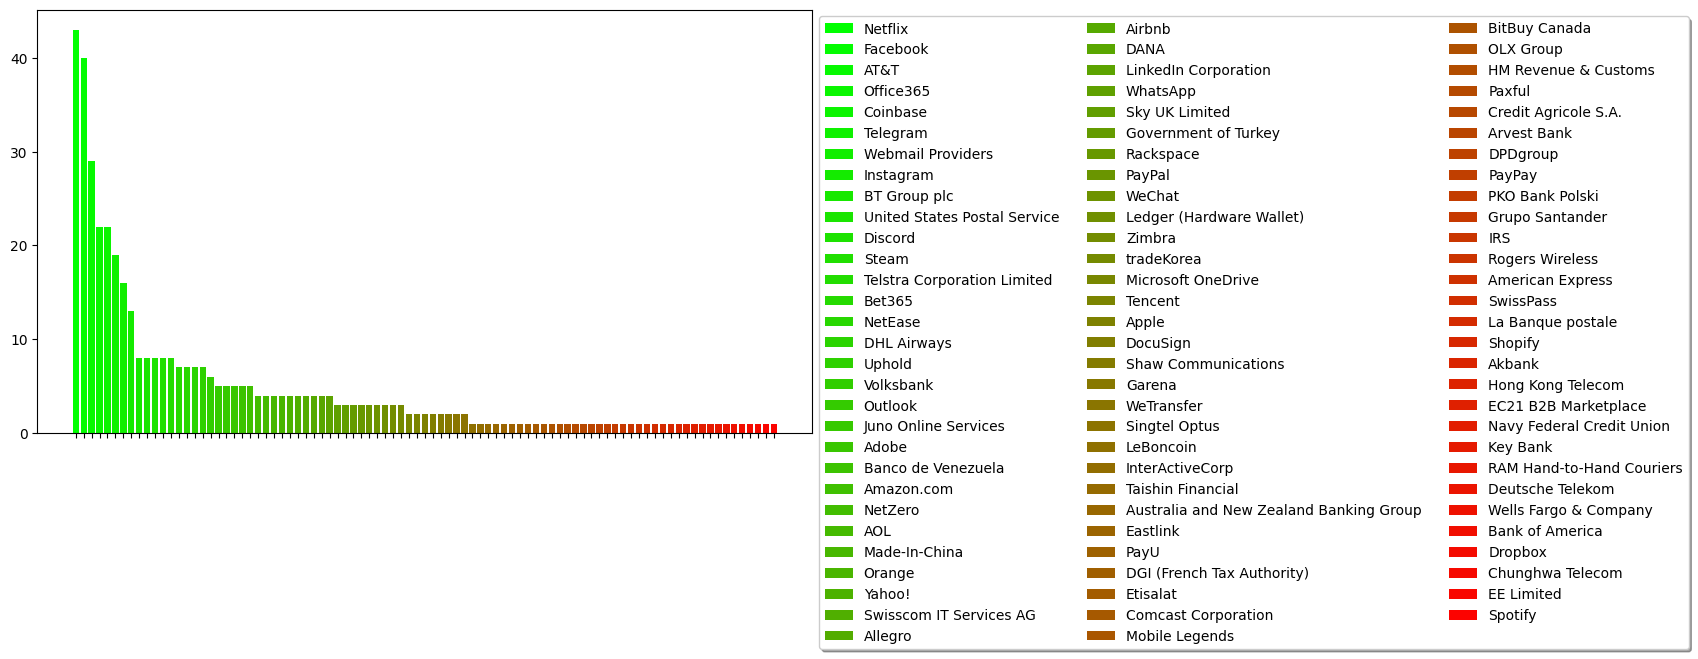

In [15]:
plot_graph(clean_targets_stat)

Формируем ТОП-3 из предыдущего результата

In [16]:
top3_targets_stat = dict(sorted(clean_targets_stat.items(), key=lambda x: -x[1])[:3])

Вызываем функцию построения диаграммы

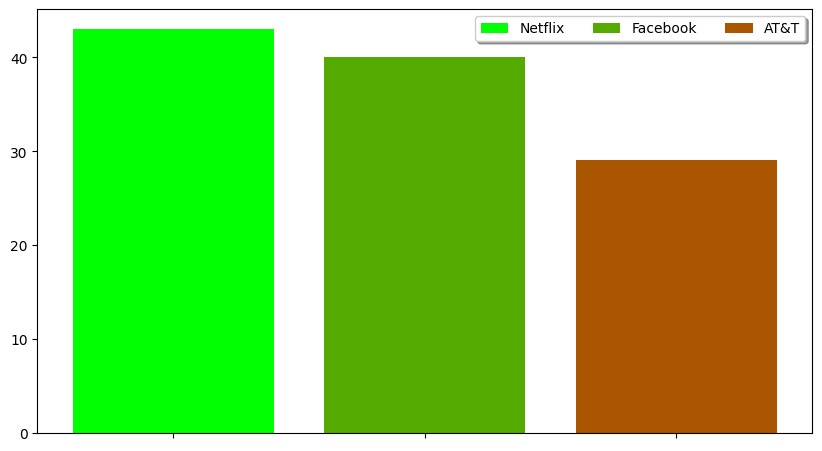

In [17]:
plot_graph(top3_targets_stat, 1)

Формируем вывод программы для заполнения финальной таблицы

In [18]:
stat_string = ', '.join([f'{target_name} - {top3_targets_stat[target_name]}' for target_name in top3_targets_stat])

print(f'Время начала парсинга: {start_of_working.strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Время окончания парсинга: {end_of_working.strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Количество уникальных URL сайтов за данный период: {total_unique_urls}')
print(f'Топ 3 Наиболее часто атакуемых брендов: {stat_string}')


Время начала парсинга: 2024-09-23 12:49:17
Время окончания парсинга: 2024-09-23 20:49:17
Количество уникальных URL сайтов за данный период: 571
Топ 3 Наиболее часто атакуемых брендов: Netflix - 43, Facebook - 40, AT&T - 29
